In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

In [2]:
df = pd.read_csv('../data/Subset-Chexchonet/prototype.csv')
df['cxr_path'] = '../data/Subset-Chexchonet/images/' + df['cxr_filename']
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["composite_slvh_dlv"], random_state=42)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["composite_slvh_dlv"], random_state=42)

In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
EPOCH = 30

Apply CLAHE 

In [4]:
def apply_clahe(img):
    # Nếu ảnh float (0–1), scale lên 0–255 và ép về uint8
    if img.dtype == np.float32 or img.dtype == np.float64:
        if img.max() <= 1.0:
            img = (img * 255.0).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Nếu ảnh RGB (3 kênh) -> chuyển sang grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    # Áp dụng CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_gray)

    # Chuyển lại về RGB (3 kênh) để tương thích với model pretrained
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

    # Chuẩn hóa về [0,1] float32
    return img_clahe.astype(np.float32) / 255.0

In [5]:
train_datagen = ImageDataGenerator(
    # preprocessing_function=apply_clahe,
    rescale=1/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1/255.0)

In [6]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col="cxr_path",
    y_col="composite_slvh_dlv",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="cxr_path",
    y_col="composite_slvh_dlv",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw"
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="cxr_path",
    y_col="composite_slvh_dlv",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=False
)

Found 1440 validated image filenames.
Found 160 validated image filenames.
Found 400 validated image filenames.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import Input

In [8]:
inputs = Input(shape=(224, 224, 3))

base_model = tf.keras.applications.DenseNet121(
    include_top=False, weights="imagenet", input_tensor=inputs
)
base_model.trainable = False 

In [9]:
x = GlobalMaxPooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

In [10]:
model = Model(inputs, outputs, name="densenet121_transfer")

In [11]:
model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

In [12]:
earlystop =  EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, verbose=1, mode="max")
checkpoint = ModelCheckpoint('../best_model.keras', monitor='val_loss', save_best_only=True, verbose=True)

In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Tính weight cho train set
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["composite_slvh_dlv"]),
    y=train_df["composite_slvh_dlv"]
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0}


In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCH,
    callbacks=[earlystop, checkpoint],
    verbose=True
)

c:\Users\Phi Yen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.4969 - auc: 0.4851 - loss: 1.9197
Epoch 1: val_loss improved from inf to 0.84769, saving model to ../best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 45s 849ms/step - accuracy: 0.4972 - auc: 0.4857 - loss: 1.9145 - val_accuracy: 0.4625 - val_auc: 0.4903 - val_loss: 0.8477
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5016 - auc: 0.5095 - loss: 1.1855
Epoch 2: val_loss improved from 0.84769 to 0.77034, saving model to ../best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 757ms/step - accuracy: 0.5020 - auc: 0.5100 - loss: 1.1832 - val_accuracy: 0.5250 - val_auc: 0.5308 - val_loss: 0.7703
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5539 - auc: 0.5836 - loss: 0.7963
Epoch 3: val_loss improved from 0.77034 to 0.73937, saving model to ../best_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 735ms/step - accuracy: 0.5535 - auc: 0.5829 - loss: 0.7967 - val_accuracy: 0.5125 - val_auc: 0.5379 - val_los

In [15]:
y_val_pred = model.predict(val_gen)
y_val_true = val_df['composite_slvh_dlv'].values 

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 697ms/step


In [16]:
y_val_pred = model.predict(val_gen)
y_val_true = val_df['composite_slvh_dlv'].values  # hoặc val_gen.labels nếu có

#  Tìm threshold tối ưu (theo ROC)
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)
youden_idx = np.argmax(tpr - fpr)   # maximize sensitivity+specificity
best_thresh = thresholds[youden_idx]
print("Best threshold (ROC):", best_thresh)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 687ms/step
Best threshold (ROC): 0.5208354


In [17]:
y_pred = model.predict(test_gen).ravel() 
y_true = test_df['composite_slvh_dlv'].values

c:\Users\Phi Yen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 879ms/step


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

Test AUC: 63.95%
Test Accuracy: 60.25%


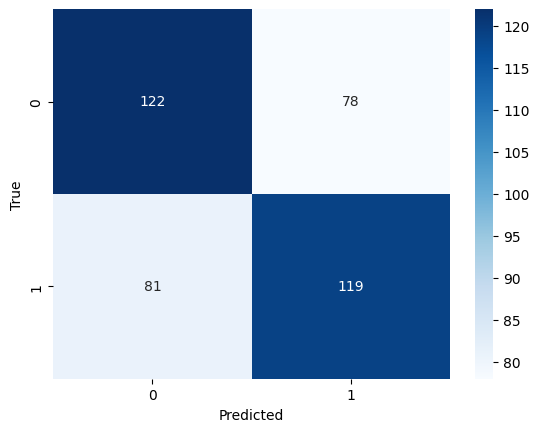

In [19]:
# ACC & ROC & AUC
auc = roc_auc_score(y_true, y_pred)
print(f"Test AUC: {auc*100:.2f}%")

# Confusion Matrix
y_pred_class = (y_pred > best_thresh).astype(int)
acc = accuracy_score(y_true, y_pred_class)
print(f"Test Accuracy: {acc*100:.2f}%")
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


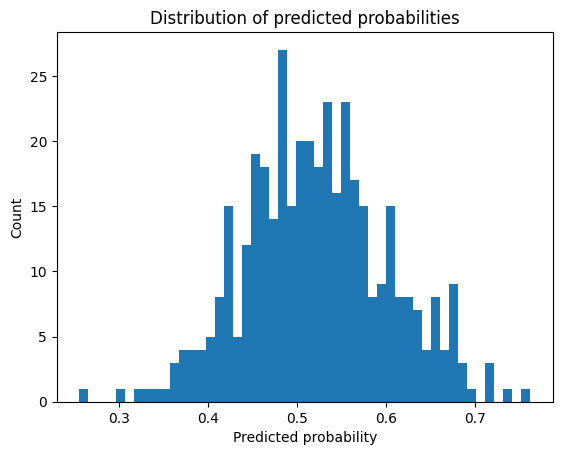

In [20]:
import matplotlib.pyplot as plt

plt.hist(y_pred, bins=50)
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

Hướng cải thiện:
1. Data
- Thay vì chỉ 2000 ảnh, thử tăng dần → 5k, 10k ảnh (nếu máy cho phép).
- Data augmentation (rotate nhỏ ±5°, shift, CLAHE/Histogram Equalization).
2. Model Training
- Dùng pretrained DenseNet121 (ImageNet), freeze backbone 1–2 epoch đầu, sau đó unfreeze dần.
- Giảm learning rate backbone (1e-4 → 1e-5), classifier giữ cao hơn.
3. Threshold tuning
- Sau khi có dự đoán probability, thử ROC curve để chọn threshold tốt nhất thay vì cố định 0.5
4. Loss function
- Dùng Focal Loss hoặc BCEWithLogitsLoss + class weights để giảm hiện tượng model chỉ thiên về một lớp.
5. Validation
- Giữ aside JSRT hoặc 10–20% data làm external validation để theo dõi overfitting.